In [154]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

In [155]:
words = os.listdir("words")

for word in words:
    print(f"{word}: {len(os.listdir(f'words/{word}'))}")


after: 347
airplane: 393
all: 386
alligator: 390
animal: 348
another: 370
any: 355
apple: 377
arm: 362
aunt: 391
awake: 401
backyard: 372
bad: 376
balloon: 393
bath: 351
because: 395
bed: 353
bedroom: 388
bee: 395
before: 354
beside: 310
better: 376
bird: 404
black: 388
blow: 391
blue: 362
boat: 370
book: 368
boy: 382
brother: 395
brown: 403
bug: 387
bye: 402
callonphone: 385
can: 366
car: 353
carrot: 386
cat: 400
cereal: 379
chair: 368
cheek: 375
child: 348
chin: 346
chocolate: 386
clean: 355
close: 374
closet: 393
cloud: 378
clown: 388
cow: 404
cowboy: 378
cry: 390
cut: 369
cute: 382
dad: 378
dance: 312
dirty: 365
dog: 380
doll: 400
donkey: 410
down: 327
drawer: 373
drink: 400
drop: 356
dry: 391
dryer: 369
duck: 405
ear: 389
elephant: 382
empty: 372
every: 368
eye: 395
face: 370
fall: 382
farm: 397
fast: 362
feet: 372
find: 397
fine: 360
finger: 379
finish: 388
fireman: 402
first: 398
fish: 380
flag: 386
flower: 396
food: 392
for: 384
frenchfries: 384
frog: 396
garbage: 371
gift: 393

In [156]:
file_names = os.listdir("words/after")


file_names

['1044729798.parquet',
 '1052878223.parquet',
 '1056438401.parquet',
 '106564566.parquet',
 '1078150780.parquet',
 '1094304937.parquet',
 '1097667387.parquet',
 '1098175348.parquet',
 '1104271845.parquet',
 '1114889620.parquet',
 '1117500362.parquet',
 '111963023.parquet',
 '1120375122.parquet',
 '1180922957.parquet',
 '119913707.parquet',
 '1204695936.parquet',
 '1242836183.parquet',
 '124296714.parquet',
 '1264815245.parquet',
 '1271728954.parquet',
 '1282295278.parquet',
 '1289995927.parquet',
 '1304860276.parquet',
 '1317336076.parquet',
 '1319436014.parquet',
 '1341475784.parquet',
 '1348400183.parquet',
 '1361395782.parquet',
 '1375340229.parquet',
 '137646346.parquet',
 '1381884726.parquet',
 '1388244940.parquet',
 '1392496150.parquet',
 '1395996631.parquet',
 '1401874542.parquet',
 '1403988076.parquet',
 '1416799858.parquet',
 '1432112256.parquet',
 '1434029916.parquet',
 '1444373558.parquet',
 '1444677243.parquet',
 '1453596488.parquet',
 '1468366744.parquet',
 '1478777756.par

In [157]:
dataframes = []
max_length = 0

hand_map = {"left_hand": 0, "right_hand": 1}

for word in words[:20]:
    print(f"Now processing \"{word}\"")
    file_names = os.listdir(f"words/{word}")
    index = words.index(word)

    # Limit to just 100 files
    for file_name in file_names:
        # Convert parquet to dataframe  
        df = pd.read_parquet(f"words/{word}/{file_name}")

        # Remove pose and face data, remove miscellaneous row_id column
        df = df[df["type"] != "pose"]
        df = df[df["type"] != "face"]
        df = df.drop(columns=["row_id"])

        # Convert NaN to -1
        df = df.fillna(-1)

        # Add sign column
        df["sign"] = index

        # Encode hand type column
        df["type"] = df["type"].map(hand_map)

        # Normalize and restrict frames
        df["frame"] = df["frame"] - int(df.iloc[0]["frame"])
        df = df[df["frame"] < 100]

        # Append to list
        dataframes.append(df)

dataframes[0]


Now processing "after"
Now processing "airplane"
Now processing "all"
Now processing "alligator"
Now processing "animal"
Now processing "another"
Now processing "any"
Now processing "apple"
Now processing "arm"
Now processing "aunt"
Now processing "awake"
Now processing "backyard"
Now processing "bad"
Now processing "balloon"
Now processing "bath"
Now processing "because"
Now processing "bed"
Now processing "bedroom"
Now processing "bee"
Now processing "before"


,frame,type,landmark_index,x,y,z,sign
468,0,0,0,-1.000000,-1.000000,-1.000000,0
469,0,0,1,-1.000000,-1.000000,-1.000000,0
470,0,0,2,-1.000000,-1.000000,-1.000000,0
471,0,0,3,-1.000000,-1.000000,-1.000000,0
472,0,0,4,-1.000000,-1.000000,-1.000000,0
...,...,...,...,...,...,...,...
3253,5,1,16,0.390754,0.452435,-0.110298,0
3254,5,1,17,0.356809,0.569751,-0.066635,0
3255,5,1,18,0.378821,0.560500,-0.082378,0
3256,5,1,19,0.396190,0.548753,-0.090704,0


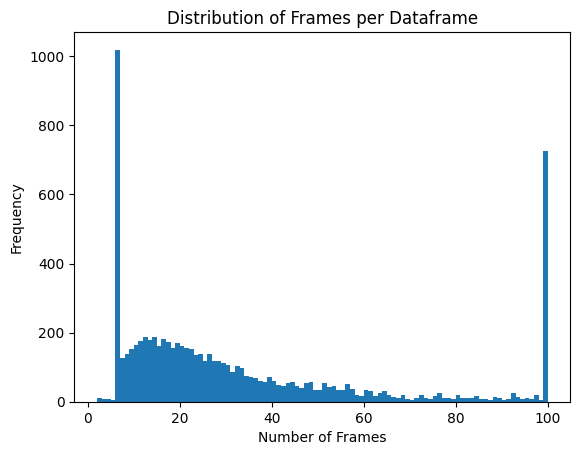

In [158]:
import matplotlib.pyplot as plt

# Get distribution of frames per dataframe
frame_counts = [df.shape[0] // 42 for df in dataframes]

# Graph distribution
plt.hist(frame_counts, bins=range(min(frame_counts), max(frame_counts) + 1))
plt.xlabel("Number of Frames")
plt.ylabel("Frequency")
plt.title("Distribution of Frames per Dataframe")
plt.show()


In [159]:
# left and right hand dataframe pad template

max_length = min(max(df.shape[0] for df in dataframes), 60 * 42)
num_of_dataframes = len(dataframes)
print(f"Adjusted (max) length: {max_length}")

for i in range(len(dataframes)):
    # Get relevant data
    df = dataframes[i]
    sign = int(df.iloc[0]["sign"])
    
    if df.shape[0] < max_length:
        pad_df = pd.DataFrame([{"frame": -2, "type": -2, "landmark_index": -2, "x": -2, "y": -2, "z": -2, "sign": sign} for _ in range(max_length - df.shape[0])])
        df = pd.concat([df, pad_df], axis=0)

    # Ensure the values are still in float32 after padding
    df = df.astype({col: 'float32' for col in df.select_dtypes(include=['float64']).columns})
    dataframes[i] = df[df["frame"] < 60]

    print(f"{i+1}/{num_of_dataframes} have been padded.")

Adjusted (max) length: 2520
1/7497 have been padded.
2/7497 have been padded.
3/7497 have been padded.
4/7497 have been padded.
5/7497 have been padded.
6/7497 have been padded.
7/7497 have been padded.
8/7497 have been padded.
9/7497 have been padded.
10/7497 have been padded.
11/7497 have been padded.
12/7497 have been padded.
13/7497 have been padded.
14/7497 have been padded.
15/7497 have been padded.
16/7497 have been padded.
17/7497 have been padded.
18/7497 have been padded.
19/7497 have been padded.
20/7497 have been padded.
21/7497 have been padded.
22/7497 have been padded.
23/7497 have been padded.
24/7497 have been padded.
25/7497 have been padded.
26/7497 have been padded.
27/7497 have been padded.
28/7497 have been padded.
29/7497 have been padded.
30/7497 have been padded.
31/7497 have been padded.
32/7497 have been padded.
33/7497 have been padded.
34/7497 have been padded.
35/7497 have been padded.
36/7497 have been padded.
37/7497 have been padded.
38/7497 have been p

In [170]:
for df in dataframes:
    if df.shape[0] != 2520:
        print(len(df["frame"].unique()))
        print(df["frame"].unique())


59
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59]


In [160]:
final_max_length = max([df.shape[0] for df in dataframes])
final_min_length = min([df.shape[0] for df in dataframes])

final_max_length, final_min_length

(2520, 2478)

In [171]:
dataframes = [df for df in dataframes if df.shape[0] == 2520]


In [172]:
final_max_length = max([df.shape[0] for df in dataframes])
final_min_length = min([df.shape[0] for df in dataframes])

final_max_length, final_min_length

(2520, 2520)

In [173]:
encoded_signs = set([df["sign"].iloc[0] for df in dataframes])

encoded_signs


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [174]:
# Function to transform frame-by-frame data into feature vectors
def transform_to_features(df, num_landmarks=42):
    """
    Transforms a DataFrame with (x, y, z) coordinates into a time-series feature array.
    Each frame is converted into a vector of size num_landmarks * 3.
    """
    # Reshape each frame into a flattened feature vector
    features = df[['x', 'y', 'z']].values.reshape(-1, num_landmarks * 3)
    return features

features = transform_to_features(dataframes[0])
features.shape  # Shape: (num_frames, 126)

(60, 126)

In [175]:
X = np.array([transform_to_features(df) for df in dataframes])
y = np.array([df["sign"].iloc[0] for df in dataframes])

X.shape, y.shape


((7496, 60, 126), (7496,))

In [176]:
# Define RNN model
model = Sequential([
    Masking(mask_value=-2, input_shape=(X.shape[1], X.shape[2])),  # Mask -2 values
    LSTM(64, return_sequences=True),                           # First LSTM layer
    LSTM(64, return_sequences=False),                          # Second LSTM layer
    Dense(16, activation='relu'),                              # Dense layer
    Dense(25, activation='softmax')                   # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Or 'categorical_crossentropy' for one-hot labels
              metrics=['accuracy'])

# Display the model summary
model.summary()


C:\Users\antho\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_14 (Masking)            │ (None, 60, 126)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 60, 64)         │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 25)             │           425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,385 (325.72 KB)

 Trainable params: 83,385 (325.72 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=602, shuffle=True)


In [178]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 183ms/step - accuracy: 0.0600 - loss: 3.1726 - val_accuracy: 0.0660 - val_loss: 3.0030
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 188ms/step - accuracy: 0.0743 - loss: 2.9708 - val_accuracy: 0.0980 - val_loss: 2.8902
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.1031 - loss: 2.8676 - val_accuracy: 0.0940 - val_loss: 2.8805
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.1183 - loss: 2.8293 - val_accuracy: 0.1180 - val_loss: 2.8138
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 187ms/step - accuracy: 0.1552 - loss: 2.7310 - val_accuracy: 0.1527 - val_loss: 2.7009
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 194ms/step - accuracy: 0.1875 - loss: 2.6092 - val_accuracy: 0.2147 - val_loss: 2.5663
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 180ms/step - accuracy: 0.2418 - loss: 2.4584 - val_accuracy: 0.2480 - val_loss: 2.3961
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accuracy: 0.2549 - loss: 2